In [5]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox.example import forest
# import hiive_mdptoolbox.example
# import hiive_mdptoolbox
import gym
import numpy as np
import sys
import os
from numpy.random import choice
import pandas as pd
import seaborn as sns
np.random.seed(44)

In [6]:
P, R = forest(S=500, r1=100, r2= 15, p=0.01)

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [19]:
def test_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode


In [13]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", "Policy", "Iteration", 
                                  "Time", "Reward", "Value Function"])
    for eps in epsilon:
        vi = ValueIteration(P, R, gamma=discount, epsilon=eps, max_iter=int(1e15))
        vi.run()
        reward = test_policy(P, R, vi.policy)
        info = [float(eps), vi.policy, vi.iter, vi.time, reward, vi.V]
        df_length = len(vi_df)
        vi_df.loc[df_length] = info
    return vi_df

In [14]:
vi_df = trainVI(P, R, epsilon=[1e-1, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15])
vi_df

,Epsilon,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-01,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",79,0.069786,2.744159,"(4.710556185449387, 5.239434944489701, 5.23943..."
1,1.000000e-03,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",119,0.037132,2.738842,"(4.7117745667154995, 5.240595870281114, 5.2405..."
2,1.000000e-06,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",179,0.199475,2.736443,"(4.711792669916437, 5.240613400253226, 5.24061..."
3,1.000000e-09,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",239,0.058018,2.726877,"(4.711792702216012, 5.240613431989174, 5.24061..."
4,1.000000e-12,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",299,0.387262,2.749473,"(4.711792702273827, 5.240613432046434, 5.24061..."
5,1.000000e-15,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",348,0.363754,2.724796,"(4.7117927022739305, 5.240613432046538, 5.2406..."


In [15]:
pi = PolicyIteration(P, R, gamma=0.9, max_iter=1e6)
pi.run()
pi_pol = pi.policy
pi_reward = test_policy(P, R, pi_pol)
pi_iter = pi.iter
pi_time = pi.time
pi_iter, pi_time, pi_reward

(46, 3.1077523231506348, 2.7201021303049737)

# Q-Learning

In [17]:
def trainQ(P, R, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = test_policy(P, R, q.policy)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

In [ ]:
alpha_decs = [0.99, 0.999]
alpha_mins =[0.001, 0.0001]
eps = [10.0, 1.0]
eps_dec = [0.99, 0.999]
iters = [1000000, 10000000]
q_df = trainQ(P, R, discount=0.9, alpha_dec=alpha_decs, alpha_min=alpha_mins, 
            epsilon=eps, epsilon_decay=eps_dec, n_iter=iters)

1: 0.802
2: 2.5774950452236354
3: 2.631858509961703
4: 2.646175901770941
5: 2.539573504201036
6: 2.6069021701575914
7: 2.5693660624419152
8: 2.6374556489936967
9: 2.6703789853483073
10: 2.690222376440896
11: 2.6191894698646014
12: 2.6511543095675845
13: 0.82
14: 2.679801290177299
15: 2.6501418339752325
16: 2.707013345485346
17: 2.723851173383091
18: 1.026
19: 2.7562338681255514
20: 2.8183151291782824
21: 2.7079361673822815


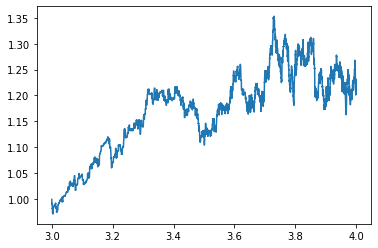

In [207]:
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running)

In [208]:
q.policy

(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1)